In [1]:
print("Running")
model = None

Running


In [2]:
import torch.nn as nn
import torch
import torch.nn as nn
import torch.nn.functional as F
class SinusoidalMLPPositionalEmbedding(nn.Module):
    def __init__(self, dim=128):
        """
        Sinusoidal positional encoding + MLP
        """
        super().__init__()
        self.dim = dim
        self.div_term = torch.exp(torch.arange(0, dim).float() * (-torch.log(torch.tensor(10000.0)) / dim))
        self.fc1 = nn.Linear(2 * dim, dim)
        self.fc2 = nn.Linear(dim, dim)
    def forward(self, x):
        # x: [B, seq_len]
        sine = torch.sin(x[:, :, None] * self.div_term[None, None, :].to(x.device))
        cosine = torch.cos(x[:, :, None] * self.div_term[None, None, :].to(x.device))
        encoding = torch.cat([sine, cosine], dim=-1)
        encoding = F.relu(self.fc1(encoding))
        encoding = self.fc2(encoding)
        return encoding
class FluxTransformerDecoder(nn.Module):
    def __init__(self, n_physical_param=10, n_wavelength=602,
                 d_model=128, nhead=8, num_layers=4, learnedPE=False):
        super().__init__()
        self.d_model = d_model
        self.seq_len = n_wavelength
        self.learnedPE = learnedPE
        # Memory embedding
        self.encoder_proj = SinusoidalMLPPositionalEmbedding(d_model)
        self.physical_param_embd = nn.Parameter(torch.randn(1, n_physical_param, d_model))
        self.memory_ff = nn.Sequential(
            nn.Linear(d_model, d_model),
            nn.ReLU(),
            nn.Linear(d_model, d_model)
        )
        # Query embedding
        if learnedPE:
            self.query = nn.Parameter(torch.randn(1, n_wavelength, d_model))
        else:
            self.query_embd = SinusoidalMLPPositionalEmbedding(d_model)
            grid = torch.linspace(0, 1, steps=n_wavelength)[None, :]
            self.register_buffer("grid", grid)
        # Transformer decoder layers
        decoder_layer = nn.TransformerDecoderLayer(
            d_model=d_model,
            nhead=nhead,
            batch_first=True,
            norm_first=True  # pre-layernorm
        )
        self.decoder = nn.TransformerDecoder(
            decoder_layer,
            num_layers=num_layers,
            norm=nn.LayerNorm(d_model)  # post-norm after final layer
        )
        # Output projection
        self.output_proj = nn.Linear(d_model, 1)
    def forward(self, physical_param):
        """
        physical_param: [B, n_physical_param]
        Returns: [B, n_wavelength]
        """
        B = physical_param.shape[0]
        # Memory: embed + positional + scale
        memory = self.encoder_proj(physical_param) + self.physical_param_embd  # [B, n_physical_param, d_model]
        memory = memory * (self.d_model ** 0.5)  # scale
        memory = self.memory_ff(memory)
        # Query / target
        if self.learnedPE:
            tgt = self.query.repeat(B, 1, 1)
        else:
            tgt = self.query_embd(self.grid).repeat(B, 1, 1)
        # Transformer decoder
        decoded = self.decoder(tgt, memory)  # [B, seq_len, d_model]
        # Project to scalar
        out = self.output_proj(decoded)  # [B, seq_len, 1]
        return out.squeeze(-1)           # [B, seq_len]

line 13
running
mean_std_dict: {'time_mean': 2764800.0, 'time_std': 1396503.0612211346, 'descriptor_mean': tensor([4.9626e-01, 5.0165e-01, 5.0399e-01, 4.9725e-01, 1.6165e+08, 2.1548e+09,
        1.0123e+33, 2.5744e+32, 7.8069e+33], dtype=torch.float64), 'descriptor_std': tensor([2.8809e-01, 2.8790e-01, 2.8765e-01, 2.8677e-01, 8.2336e+07, 7.7078e+08,
        5.6994e+32, 1.4018e+32, 4.5137e+33], dtype=torch.float64), 'fluxes_mean': tensor(37.3654, dtype=torch.float64), 'fluxes_std': tensor(4.6562, dtype=torch.float64)}


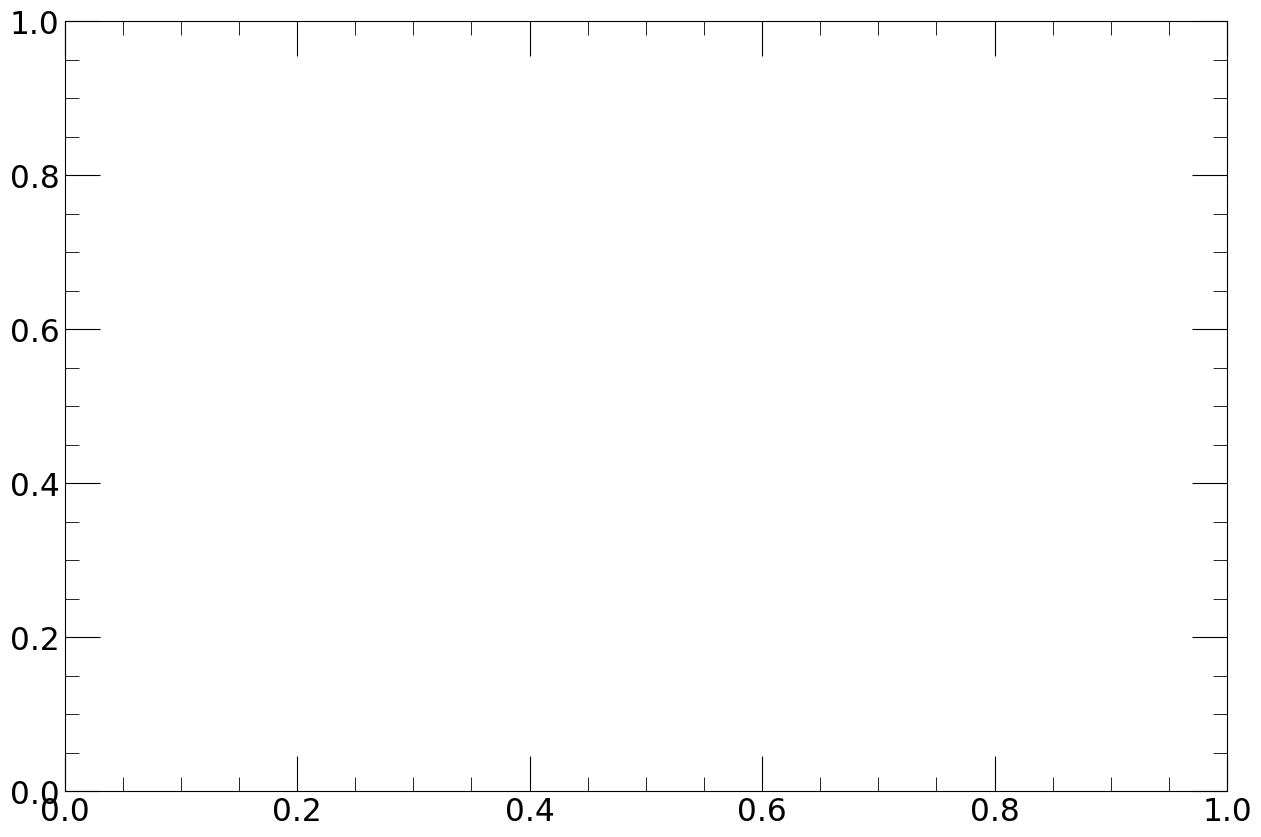

In [4]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from dataloader import *
from tqdm import tqdm  # To show progress bar during training
import numpy as np
import glob
import os
import sys
import sys
from support_funcs1 import *
from support_funcs2 import *
from sklearn.model_selection import train_test_split

print("line 13")
mean_std_dict = torch.load('normalization_stats.pt')

print("running")
print("mean_std_dict: "+str(mean_std_dict))

In [5]:
import torch
from sklearn.model_selection import train_test_split

all_data = torch.load("preprocessed_small_spectra.pt")
all_sample_ids = sorted({entry['sample_id'] for entry in all_data})

train_sample_ids = all_sample_ids

print("length of training sample: "+str(len(train_sample_ids)))


train_data = [entry for entry in all_data if entry['sample_id'] in train_sample_ids]
#test_data  = [entry for entry in all_data if entry['sample_id'] in train_sample_ids]

from dataloader import NormalizeSpectralData, FastSupernovaDataset
mean_std_dict = torch.load('normalization_stats.pt')
transform = NormalizeSpectralData(mean_std_dict)
train_dataset = FastSupernovaDataset(samples=train_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True,  drop_last=True)


print("created test and train loaders")
N_wavelengths = 602

length of training sample: 2
created test and train loaders


In [6]:
def train_model(model, dataloader, criterion, optimizer, scheduler, epochs=10):
    ep = 1.0E-6
    model.train()
    filter_prof_dir = 'filter_profs/'
    filters = {'u': 'SLOAN_SDSS.u', 'g': 'SLOAN_SDSS.g', 'r': 'SLOAN_SDSS.r', 'i': 'SLOAN_SDSS.i', 'z': 'SLOAN_SDSS.z'}
    band_passes = {}
    fluxes_mean = mean_std_dict['fluxes_mean'].to(torch.float64).to(device)
    fluxes_std = mean_std_dict['fluxes_std'].to(torch.float64).to(device)
        
    for epoch in range(epochs):
        running_loss = 0.0
        for i, batch in enumerate(dataloader):
            # Only print occasionally for progress
            descriptor = batch['descriptor'].float().to(device)
            time = batch['time'].unsqueeze(1).float().to(device)
            fluxes = batch['flux'].float().to(device)
            wav = batch['wav'].float().to(device) 
            input_data = torch.cat((descriptor, time), dim=1)
            optimizer.zero_grad()
            #output = torch.clamp(model(input_data), -3, 3)
            output = model(input_data)
            spec_pred = output.to(torch.float64)
            spec_true = fluxes.to(torch.float64)
            
            '''
            mag_loss = torch.log10(criterion( torch.sum(10.**(spec_pred*fluxes_std + fluxes_mean)), 
                                              torch.sum(10.**(spec_true*fluxes_std + fluxes_mean)) ))'''
            

            loss = criterion(fluxes, output)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(dataloader)
        scheduler.step(epoch_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}")
        
    model.eval()
    with torch.no_grad():
        out_eval = model(input_data)
    model.train()
    out_train = model(input_data)
    return model

# Set up model, loss, optimizer
model = FluxTransformerDecoder()  # PyTorch 1.6+: beta=1.0 (or try 0.5, 2.0)
#model = nn.Sequential(nn.Linear(10, 512), nn.ReLU(), nn.Linear(512, N_wavelengths)).to(device)
# Set up optimizer
criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.001)
print("model: "+str(model))

model: FluxTransformerDecoder(
  (encoder_proj): SinusoidalMLPPositionalEmbedding(
    (fc1): Linear(in_features=256, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
  )
  (memory_ff): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (query_embd): SinusoidalMLPPositionalEmbedding(
    (fc1): Linear(in_features=256, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
  )
  (decoder): TransformerDecoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerDecoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (multihead_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linea

In [7]:
print("running here")

# Add a scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=8, factor=0.5)

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Usage
model = train_model(model, train_loader, criterion, optimizer, scheduler, epochs=100)


#save the model
mkdir("Saved Model/")
torch.save(model.state_dict(), "Saved Model/NN.pt")

running here
Epoch [1/100], Loss: 5.5744
Epoch [2/100], Loss: 0.3197
Epoch [3/100], Loss: 0.6976
Epoch [4/100], Loss: 0.1558
Epoch [5/100], Loss: 0.0703
Epoch [6/100], Loss: 0.1808
Epoch [7/100], Loss: 0.1037
Epoch [8/100], Loss: 0.0327
Epoch [9/100], Loss: 0.0519
Epoch [10/100], Loss: 0.0604
Epoch [11/100], Loss: 0.0337
Epoch [12/100], Loss: 0.0216
Epoch [13/100], Loss: 0.0281
Epoch [14/100], Loss: 0.0291
Epoch [15/100], Loss: 0.0192
Epoch [16/100], Loss: 0.0222
Epoch [17/100], Loss: 0.0227
Epoch [18/100], Loss: 0.0201
Epoch [19/100], Loss: 0.0174
Epoch [20/100], Loss: 0.0190
Epoch [21/100], Loss: 0.0200
Epoch [22/100], Loss: 0.0179
Epoch [23/100], Loss: 0.0165
Epoch [24/100], Loss: 0.0178
Epoch [25/100], Loss: 0.0183
Epoch [26/100], Loss: 0.0175
Epoch [27/100], Loss: 0.0168
Epoch [28/100], Loss: 0.0174
Epoch [29/100], Loss: 0.0173
Epoch [30/100], Loss: 0.0171
Epoch [31/100], Loss: 0.0163
Epoch [32/100], Loss: 0.0170
Epoch [33/100], Loss: 0.0165
Epoch [34/100], Loss: 0.0170
Epoch [35/

In [ ]:

from astropy.constants import c
filter_prof_dir = 'filter_profs/'
# After model.eval()
model.eval() #<--- UNCOMMENTING THIS CODE MAKES EVERYTHING GO TO HELL.. WHY THE HELL 
for i, batch in enumerate(train_loader):
    # Input prep as before
    descriptor = batch['descriptor'].float().to(device)
    time = batch['time'].unsqueeze(1).float().to(device)

    wav = batch['wav'].cpu().numpy() 
    fluxes = batch['flux'].float().to(device)
    sample_id = batch['sample_id']

    input_data = torch.cat((descriptor, time), dim=1)
    output = model(input_data)
    print("input data: "+str(input_data))
    print("predicted output[0:15]: "+str(output[0, :15]))
    loss = criterion(fluxes, output)
    print("loss: "+str(loss))
    # Denormalize Chebyshev coefficients for FIRST sample in batch (for demo)
    norm_stats = mean_std_dict
    fluxes_mean = norm_stats['fluxes_mean'].float().to(device)
    fluxes_std = norm_stats['fluxes_std'].float().to(device)

    output = output.to(torch.float64)
    fluxes = fluxes.to(torch.float64)
    spec_pred = 10.**(output * fluxes_std + fluxes_mean).cpu().detach().numpy()
    spec_true = 10.**(fluxes * fluxes_std + fluxes_mean).cpu().detach().numpy()



    #print("spec_pred shape: "+str(spec_pred.shape))
    #print("spec_true shape: "+str(spec_true.shape))

    time_norm = batch['time']         # [batch]            # normalized time (tensor)
    desc_norm = batch['descriptor']   # [batch, 9]         # normalized descriptor (tensor)

    # Get mean/std as numpy arrays or tensors of compatible type
    time_mean = float(mean_std_dict['time_mean'])
    time_std = float(mean_std_dict['time_std'])
    descriptor_mean = mean_std_dict['descriptor_mean'].cpu().numpy()  # [9]
    descriptor_std = mean_std_dict['descriptor_std'].cpu().numpy()    # [9]

    # Unnormalize time and descriptors for the FIRST sample in the batch:
    #    (if you want all samples, use a for loop over the batch)
    time_unnorm = time_norm[0].cpu().numpy() * time_std + time_mean
    time_d = str(round(time_unnorm/86400, 3))
    desc_unnorm = desc_norm[0].cpu().numpy() * descriptor_std + descriptor_mean

    #print(f"Batch {i} -- un-normalized time (first in batch):", time_unnorm)
    #print(f"Batch {i} -- un-normalized descriptor (first in batch):\n", desc_unnorm)

    # --- Plot as before ---
    plt, _, _ = get_pretty_plot()
    plt.scatter(wav[0], spec_true[0], label='Ground Truth', color = space_colors[0])
    plt.plot(wav[0], spec_pred[0], label='Predicted\n('+f"{loss.item():04.3f}"+")", linewidth=4, color = space_colors[1])
    plt.xlabel(r"Wavelength ($\AA$)", fontsize=35)
    plt.ylabel("Flux", fontsize=35)
    plt.title('Time_' + str(time_unnorm/86400)+"|Sample: "+str(sample_id[0]), fontsize=35)
    #plt.ylim([0, 1.0E39])
    plt.legend(fontsize=25)
    mkdir("Predicted Train_small/")
    plt.savefig(f"Predicted Train_small/"+time_d+"_"+str(sample_id[0])+".pdf", bbox_inches='tight')
    plt.close()


    plt, _, _ = get_pretty_plot()
    plt.plot(wav[0], spec_true[0], label='Ground Truth', color = space_colors[0], linewidth = 4)
    plt.plot(wav[0], spec_pred[0], label='Predicted\n('+f"{loss.item():04.3f}"+")", linewidth=4, color = space_colors[1])
    plt.xlabel(r"Wavelength ($\AA$)", fontsize=35)
    plt.ylabel("Flux", fontsize=35)
    plt.title('Time_' + time_d+"|Sample: "+str(sample_id[0]), fontsize=35)
    #plt.ylim([0, 1.0E39])
    plt.legend(fontsize=25)
    mkdir("Predicted Train_small/")
    plt.savefig(f"Predicted Train_small/"+time_d+"_"+str(sample_id[0])+"_p.pdf", bbox_inches='tight')
    plt.close()

    plt, _, _ = get_pretty_plot()
    plt.scatter(wav[0], spec_true[0], label='Ground Truth', color = space_colors[0])
    plt.scatter(wav[0], spec_pred[0], label='Predicted\n('+f"{loss.item():04.3f}"+")", color = space_colors[1])
    plt.xlabel(r"Wavelength ($\AA$)", fontsize=35)
    plt.ylabel("Flux", fontsize=35)
    plt.title('Time_' + str(time_unnorm/86400)+"|Sample: "+str(sample_id[0]), fontsize=35)
    #plt.ylim([0, 1.0E39])
    plt.legend(fontsize=25)
    mkdir("Predicted Train_small/")
    plt.savefig(f"Predicted Train_small/"+time_d+"_"+str(sample_id[0])+"_s.pdf", bbox_inches='tight')
    plt.close()


            #calculate photometry in ugriz filters using the predicted and true spectra
    true_mags = []
    pred_mags = []
    del_mags = []
    filts = []
    filters = {'u': 'SLOAN_SDSS.u', 'g': 'SLOAN_SDSS.g', 'r': 'SLOAN_SDSS.r', 'i': 'SLOAN_SDSS.i', 'z': 'SLOAN_SDSS.z'}
    for fil in filters:
        #read in the bandpass in this filter
        filter_data = np.loadtxt(filter_prof_dir+"/"+str(filters[fil])+".dat")
        filter_wavs = filter_data[:, 0]
        filter_transmission = filter_data[:, 1]


        #calculate the photometric point in this filter
        speed_of_light = c
        #spectra from sedona are outputted as L_nu, right? So total luminosity at a given \nu
        #I need to divide it by 4*pi*(1 parsec)**2 so it is flux, rather than luminosity
        d = (10*u.parsec).to(u.cm).value
        denom = 4*np.pi*d**2.0
        true_mag = compute_photometry(wav[0], spec_true[0]/denom, filter_wavs, filter_transmission)
        pred_mag = compute_photometry(wav[0], spec_pred[0]/denom, filter_wavs, filter_transmission)
        del_mag = np.abs(true_mag-pred_mag)
        del_mags.append(del_mag)
        true_mags.append(true_mag)
        pred_mags.append(pred_mag)
        filts.append(fil)


    true_mags = np.asarray(true_mags)
    pred_mags = np.asarray(pred_mags)
    filts = np.asarray(filts)
    del_mags = np.asarray(del_mags)
    tow = np.asarray([true_mags, pred_mags, del_mags, filts]).T

    out_file = "Predicted Train_small/"+time_d+"_"+str(sample_id[0])+"_phot.txt"
    rm(out_file)
    write_to_file(out_file, '# True_mag pred_mag del_mag filt\n', append = False)
    write_to_file(out_file, tow, append = True)



input data: tensor([[-0.5805,  1.0007, -0.4905,  0.0273,  1.0156,  0.9762, -0.0243,  1.5730,
         -0.9920, -1.4539],
        [-1.5312, -0.3580, -0.2951, -0.5497,  0.0737, -1.3751,  1.5465, -1.0589,
          1.5441, -1.5158]], device='cuda:0')
predicted output[0:15]: tensor([0.2218, 0.2218, 0.2218, 0.2218, 0.2218, 0.2218, 0.2218, 0.2218, 0.2218,
        0.2218, 0.2218, 0.2218, 0.2217, 0.2217, 0.2217], device='cuda:0',
       grad_fn=<SliceBackward0>)
loss: tensor(0.0080, device='cuda:0', grad_fn=<MseLossBackward0>)


In [ ]:
model = None